# Pràctica 4
### Part I : Entrenament de models Word2vec

In [1]:
## Imports necessaris
#!py -m spacy download ca_core_news_md
#!py -m spacy download ca_core_news_trf

##!python3 -m pip install spacy-transformers
##!python3 -m pip install sentence_transformers

# Requisitos

from gensim.models import TfidfModel, KeyedVectors, word2vec
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
import numpy as np
# Tipado
from typing import Tuple, List, Optional
import spacy
import tensorflow as tf
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer
from scipy.special import logit
from datasets import load_dataset
from sklearn.metrics import classification_report

In [ ]:
dataset = load_dataset("projecte-aina/catalan_general_crawling")

In [ ]:
with open('data/ca_gen_crwlng.txt','w',encoding='UTF-8') as f:
    for i in dataset['train']['text']:
        f.write(i)

In [ ]:
STOPWORDS_CA = {"a", "al", "el", "la", "els", "les", "de", "un", "una", "algun", "alguna", }


def preprocess(sentence: str) -> List[str]:
    preprocessed = simple_preprocess(sentence)
    preprocessed = [token for token in preprocessed if token not in STOPWORDS_CA]
    return preprocessed

In [ ]:
def obtain_words(filepath:str) -> List[List[str]]:
    if filepath[-4:] != '.txt':
        raise Exception('Incorrect file path/name')

    txt_crps = []
    with open(filepath,'r',encoding='UTF-8') as f:
        lines = f.readlines()
        for l in lines:
            txt_crps.append(preprocess(l))

    return txt_crps

In [ ]:
txt_crps100 = obtain_words('data/ca_gen_crwlng100M.txt')
txt_crps500 = obtain_words('data/ca_gen_crwlng500M.txt')

##### Create Word2Vec models with the 2 sizes

In [ ]:
model100 = word2vec.Word2Vec(txt_crps100 , vector_size=100, window=5, min_count=10, workers=4, epochs=25, sg=1)
model500 = word2vec.Word2Vec(txt_crps500 , vector_size=100, window=5, min_count=10, workers=4, epochs=25, sg=1)

##### Save the models to easy load

In [ ]:
model100.wv.save_word2vec_format('data/word2vec100.bin', binary=True)
model500.wv.save_word2vec_format('data/word2vec500.bin', binary=True)

In [10]:
wv100 = KeyedVectors.load_word2vec_format('data/word2vec100.bin', binary=True)
wv500 = KeyedVectors.load_word2vec_format('data/word2vec500.bin', binary=True)

## Text similarity training and comparison

### Obtain the corpus

In [1]:
dataset = load_dataset("projecte-aina/sts-ca")

Found cached dataset sts-ca (C:/Users/pelot/.cache/huggingface/datasets/projecte-aina___sts-ca/StsCa/1.0.2/bad37fb7fb0f06f3d2316e29637293b25160a93a24f36f1974f21313ac2f3342)


  0%|          | 0/3 [00:00<?, ?it/s]

### Obtain the Baseline model

En aquest codi el que fem es crear el nostre diccionari a partir de les oracions del nostre corpus. A més a més, parametritzem la funció map_pairs per poder utilitzar els embeddings demanats a cada part.

In [3]:
# Cargar stopwords en Catalan
# STOPWORDS_CA = {"a", "abans", "ací", "ah", "així", "això", "al", "aleshores", "algun", "alguna", "algunes", "alguns", "alhora", "allà", "allí", "allò", "als", "altra", "altre", "altres", "amb", "ambdues", "ambdós", "anar", "ans", "apa", "aquell", "aquella", "aquelles", "aquells", "aquest", "aquesta", "aquestes", "aquests", "aquí", "baix", "bastant", "bé", "cada", "cadascuna", "cadascunes", "cadascuns", "cadascú", "com", "consegueixo", "conseguim", "conseguir", "consigueix", "consigueixen", "consigueixes", "contra", "d'un", "d'una", "d'unes", "d'uns", "dalt", "de", "del", "dels", "des", "des de", "després", "dins", "dintre", "donat", "doncs", "durant", "e", "eh", "el", "elles", "ells", "els", "em", "en", "encara", "ens", "entre", "era", "erem", "eren", "eres", "es", "esta", "estan", "estat", "estava", "estaven", "estem", "esteu", "estic", "està", "estàvem", "estàveu", "et", "etc", "ets", "fa", "faig", "fan", "fas", "fem", "fer", "feu", "fi", "fins", "fora", "gairebé", "ha", "han", "has", "haver", "havia", "he", "hem", "heu", "hi", "ho", "i", "igual", "iguals", "inclòs", "ja", "jo", "l'hi", "la", "les", "li", "li'n", "llarg", "llavors", "m'he", "ma", "mal", "malgrat", "mateix", "mateixa", "mateixes", "mateixos", "me", "mentre", "meu", "meus", "meva", "meves", "mode", "molt", "molta", "moltes", "molts", "mon", "mons", "més", "n'he", "n'hi", "ne", "ni", "no", "nogensmenys", "només", "nosaltres", "nostra", "nostre", "nostres", "o", "oh", "oi", "on", "pas", "pel", "pels", "per", "per que", "perquè", "però", "poc", "poca", "pocs", "podem", "poden", "poder", "podeu", "poques", "potser", "primer", "propi", "puc", "qual", "quals", "quan", "quant", "que", "quelcom", "qui", "quin", "quina", "quines", "quins", "què", "s'ha", "s'han", "sa", "sabem", "saben", "saber", "sabeu", "sap", "saps", "semblant", "semblants", "sense", "ser", "ses", "seu", "seus", "seva", "seves", "si", "sobre", "sobretot", "soc", "solament", "sols", "som", "son", "sons", "sota", "sou", "sóc", "són", "t'ha", "t'han", "t'he", "ta", "tal", "també", "tampoc", "tan", "tant", "tanta", "tantes", "te", "tene", "tenim", "tenir", "teniu", "teu", "teus", "teva", "teves", "tinc", "ton", "tons", "tot", "tota", "totes", "tots", "un", "una", "unes", "uns", "us", "va", "vaig", "vam", "van", "vas", "veu", "vosaltres", "vostra", "vostre", "vostres", "érem", "éreu", "és", "éssent", "últim", "ús"}
STOPWORDS_CA = {"a", "al", "el", "la", "els", "les", "de", "un", "una", "algun", "alguna", }

# Definir función de pre-procesado
def preprocess(sentence: str) -> List[str]:
    preprocessed = simple_preprocess(sentence)
    preprocessed = [token for token in preprocessed if token not in STOPWORDS_CA]
    return preprocessed

## Introducir los datos de train y de validación
input_pairs = list(zip(dataset["train"]["sentence1"], dataset["train"]["sentence2"], dataset["train"]["label"]))
input_pairs_val = list(zip(dataset["validation"]["sentence1"], dataset["validation"]["sentence2"], dataset["validation"]["label"]))


# Preprocesamiento de las oraciones y creación del diccionario
sentences_1_preproc = [preprocess(sentence_1) for sentence_1, _, _ in input_pairs]
sentences_2_preproc = [preprocess(sentence_2) for _, sentence_2, _ in input_pairs]
sentence_pairs = list(zip(sentences_1_preproc, sentences_2_preproc))
# Versión aplanada para poder entrenar el modelo
sentences_pairs_flattened = sentences_1_preproc + sentences_2_preproc

diccionario = Dictionary(sentences_pairs_flattened)

corpus = [diccionario.doc2bow(sent) for sent in sentences_pairs_flattened]
modelo_tfidf = TfidfModel(corpus)

def creacio_one_hot(sentence, diccionario:Dictionary):
    diccionario.filter_extremes(no_below=5, no_above=0.5, keep_n=100)
    vector1 = np.zeros(len(diccionario.token2id), dtype=np.float)
    bow1 = diccionario.doc2bow(sentence)
    for index, count in bow1:
        vector1[index] = count

    return vector1

def map_tf_idf(sentence_preproc: List[str], dictionary: Dictionary, tf_idf_model: TfidfModel, wv_model) -> Tuple[List[np.ndarray], List[float]]:
    bow = dictionary.doc2bow(sentence_preproc)
    tf_idf = tf_idf_model[bow]
    vectors, weights = [], []
    for word_index, weight in tf_idf:
        word = dictionary.get(word_index)
        if word in wv_model:
            vectors.append(wv_model[word])
            weights.append(weight)
    return vectors, weights

def map_pairs(
        sentence_pairs: List[Tuple[str, str, float]],
        dictionary: Dictionary = None,
        tf_idf_model: TfidfModel = None,
        one_hot: bool = None,
        Spasii : bool = None,
        RobertA: bool = None,
        RobertA_Mean: bool = None,
        wv100: bool = None,
        wv500: bool = None,
        w2v_pre_mean: bool = None
) -> List[Tuple[Tuple[np.ndarray, np.ndarray], float]]:
    """
    Mapea los tripletes de oraciones a listas de (x, y), (pares de vectores, score)
    :param sentence_pairs:
    :param dictionary:
    :param tf_idf_model:
    :return:
    """
    if one_hot:
        dictionary2 = Dictionary(sentences_pairs_flattened, prune_at=300)

    if Spasii:
        nlp = spacy.load("ca_core_news_md")
    if RobertA or RobertA_Mean:
        nlp = spacy.load("ca_core_news_trf")

    if wv100:
        wv_model = KeyedVectors.load_word2vec_format("data/word2vec100.bin", binary = True)

    if wv500:
        wv_model = KeyedVectors.load_word2vec_format("data/word2vec500.bin", binary = True)

    if w2v_pre_mean or tf_idf_model:
        wv_model = KeyedVectors.load_word2vec_format("data/model.bin", binary = True)


    # Mapeo de los pares de oraciones a pares de vectores
    pares_vectores = []
    for i, (sentence_1, sentence_2, similitud) in enumerate(sentence_pairs):
        sentence_1_preproc = preprocess(sentence_1)
        sentence_2_preproc = preprocess(sentence_2)
        # Si usamos TF-IDF
        if tf_idf_model is not None:
            # Cálculo del promedio ponderado por TF-IDF de los word embeddings
            vectors1, weights1 = map_tf_idf(sentence_1_preproc, dictionary=dictionary, tf_idf_model=tf_idf_model, wv_model=wv_model )
            vectors2, weights2 = map_tf_idf(sentence_2_preproc, dictionary=dictionary, tf_idf_model=tf_idf_model,wv_model=wv_model )
            vector1 = np.average(vectors1, weights=weights1, axis=0, )
            vector2 = np.average(vectors2, weights=weights2, axis=0, )

        elif wv100 is not None:
            vectors1 = [wv_model[word] for word in sentence_1_preproc if word in wv_model]
            vectors2 = [wv_model[word] for word in sentence_2_preproc if word in wv_model]
            vector1 = np.mean(vectors1, axis=0)
            vector2 = np.mean(vectors2, axis=0)

        elif wv500 is not None:
            vectors1 = [wv_model[word] for word in sentence_1_preproc if word in wv_model]
            vectors2 = [wv_model[word] for word in sentence_2_preproc if word in wv_model]
            vector1 = np.mean(vectors1, axis=0)
            vector2 = np.mean(vectors2, axis=0)

        elif one_hot is not None:
            vector1 = creacio_one_hot(sentence=sentence_1_preproc, diccionario=dictionary2)
            vector2 = creacio_one_hot(sentence=sentence_2_preproc, diccionario= dictionary2)
            
        elif Spasii is not None:
            vector1 = nlp(" ".join(sentence_1_preproc)).vector
            vector2 = nlp(" ".join(sentence_2_preproc)).vector

        elif RobertA is not None:
            vector1 = nlp(" ".join(sentence_1_preproc))._.trf_data.tensors[-1]
            vector2 = nlp(" ".join(sentence_2_preproc))._.trf_data.tensors[-1]
            vector1 = tf.squeeze(vector1)
            vector2 = tf.squeeze(vector2)

        elif RobertA_Mean is not None:
            vectors1 = nlp(" ".join(sentence_1_preproc))._.trf_data.tensors[-1]
            vectors2 = nlp(" ".join(sentence_2_preproc))._.trf_data.tensors[-1]
            vector1 = np.average(vectors1, axis=0)
            vector2 = np.average(vectors2, axis=0)
            
        elif w2v_pre_mean is not None:
            # Cálculo del promedio de los word embeddings
            vectors1 = [wv_model[word] for word in sentence_1_preproc if word in wv_model]
            vectors2 = [wv_model[word] for word in sentence_2_preproc if word in wv_model]
            vector1 = np.mean(vectors1, axis=0)
            vector2 = np.mean(vectors2, axis=0)
        # Añadir a la lista
        pares_vectores.append(((vector1, vector2), similitud))
    return pares_vectores

A continuació, fem la funció de la creació del model y dels hiperparámetres

In [4]:
def build_and_compile_model(hidden_size: int = 128, embedding_size: int = 300, learning_rate: float = 0.001) -> tf.keras.Model:
    # Capa de entrada para los pares de vectores
    input_1 = tf.keras.Input(shape=(embedding_size,))
    input_2 = tf.keras.Input(shape=(embedding_size,))

    # Capa oculta
    first_projection = tf.keras.layers.Dense(
        embedding_size,
        # activation='tanh',
        kernel_initializer=tf.keras.initializers.Identity(),
        bias_initializer=tf.keras.initializers.Zeros(),
    )
    projected_1 = first_projection(input_1)
    projected_2 = first_projection(input_2)

    # Compute the cosine distance
    projected_1 = tf.linalg.l2_normalize(projected_1, axis=1, )
    projected_2 = tf.linalg.l2_normalize(projected_2, axis=1, )
    output = 2.5 * (1.0 + tf.reduce_sum(projected_1 * projected_2, axis=1, ))

    # Definir el modelo con las capas de entrada y salida
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)

    # Compilar el modelo
    model.compile(loss='mean_absolute_error', metrics=tf.keras.metrics.mean_squared_error,
                  optimizer=tf.keras.optimizers.Adam(learning_rate))

    return model

def plot_training_curve(history):
    # Plot the training and validation loss and accuracy
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    ax[0].plot(history.history['loss'], label='train_loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training and Validation Loss')
    ax[0].grid(True)
    ax[0].legend()
    ax[1].plot(history.history['mean_squared_error'], label='mean_squared_error')
    ax[1].plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Training and Validation correlation')
    ax[1].grid(True)
    ax[1].legend()
    plt.show()

# Definir constantes de entrenamiento
batch_size: int = 64
num_epochs: int = 64

def pair_list_to_x_y(pair_list: List[Tuple[Tuple[np.ndarray, np.ndarray], int]]) -> Tuple[Tuple[np.ndarray, np.ndarray], np.ndarray]:
    """
    Otiene las matrices X_1 (N x d) , X_2 (N x d), e Y (n) a partir de listas de parejas de vectores de oraciones - Listas de (d, d, 1)
    :param pair_list:
    :return:
    """
    _x, _y = zip(*pair_list)
    _x_1, _x_2 = zip(*_x)
    return (np.array(_x_1), np.array(_x_2)), np.array(_y, dtype=np.float32, )


def create_and_train_and_evaluate_model(mapped, mapped_val,embedding_size:int=100):
    # Obtener las listas de train y test
    x_train, y_train = pair_list_to_x_y(mapped)
    x_val, y_val = pair_list_to_x_y(mapped_val)

    # Preparar los conjuntos de datos de entrenamiento y validación
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_dataset = val_dataset.batch(batch_size)

    # Construir y compilar el modelo
    model = build_and_compile_model(embedding_size=embedding_size)
    # tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, )
    print(model.summary())
    # Entrenar el modelo
    history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

    plot_training_curve(history)

    y_pred: tf.RaggedTensor = model.predict(x_val)
    # Calcular la correlación de Pearson entre las predicciones y los datos de prueba
    correlation, _ = pearsonr(y_pred.flatten(), y_val.flatten())
    # Imprimir el coeficiente de correlación de Pearson
    print(f"Correlación de Pearson: {correlation}")

    return model

### Compare results with different word embeddings

#### 0. Model de Word2Vec entrenats per nosaltres

##### 0.1. Model amb 100 MB

In [5]:
mapped = map_pairs(input_pairs, wv100=True, dictionary=diccionario )
mapped_val = map_pairs(input_pairs_val, wv100=True, dictionary=diccionario)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 100)          10100       ['input_31[0][0]',               
                                                                  'input_32[0][0]']               
                                                                                                  
 tf.math.l2_normalize_30 (TFOpL  (None, 100)         0           ['dense_9[0][0]']         

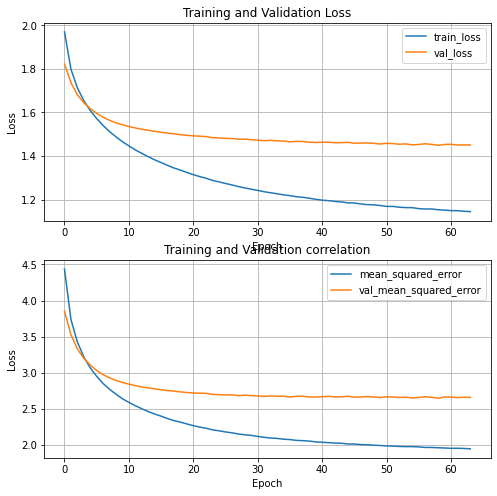

16/16 [==============================] - 0s 3ms/step
Correlación de Pearson: 0.44599953275335824


In [50]:
model = create_and_train_and_evaluate_model(mapped, mapped_val,embedding_size=100)

##### 0.2. Model amb 500 MB

In [51]:
mapped = map_pairs(input_pairs, wv500=True, dictionary=diccionario )
mapped_val = map_pairs(input_pairs_val, wv500=True, dictionary=diccionario)

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 100)          10100       ['input_33[0][0]',               
                                                                  'input_34[0][0]']               
                                                                                                  
 tf.math.l2_normalize_32 (TFOpL  (None, 100)         0           ['dense_10[0][0]']        

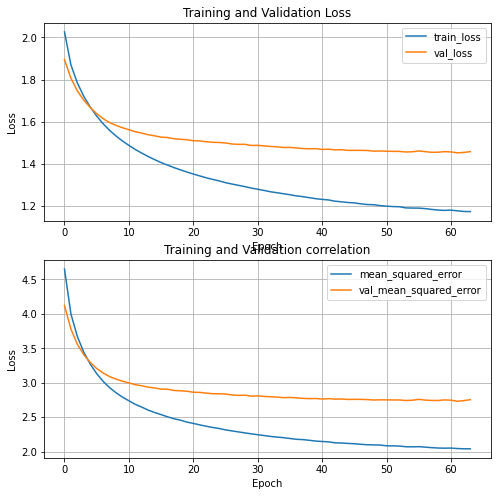

16/16 [==============================] - 0s 3ms/step
Correlación de Pearson: 0.35885052472452256


In [52]:
model = create_and_train_and_evaluate_model(mapped, mapped_val,embedding_size=100)

#### 1. One Hot encoding

In [57]:
mapped = map_pairs(input_pairs, one_hot=True, dictionary=diccionario )
mapped_val = map_pairs(input_pairs_val, one_hot=True, dictionary=diccionario)

C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_38 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_12 (Dense)               (None, 100)          10100       ['input_37[0][0]',               
                                                                  'input_38[0][0]']               
                                                                                                  
 tf.math.l2_normalize_36 (TFOpL  (None, 100)         0           ['dense_12[0][0]']        

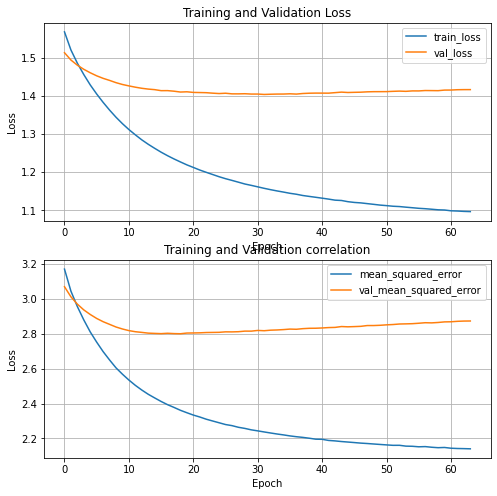

16/16 [==============================] - 0s 1ms/step
Correlación de Pearson: 0.22115282243433215


In [58]:
model = create_and_train_and_evaluate_model(mapped, mapped_val, embedding_size=100)

#### 2. Models de Word2Vec/GloVe pre-entrenats

##### 2.1.Word2Vec + Mean

In [64]:
mapped = map_pairs(input_pairs, w2v_pre_mean=True, dictionary=diccionario )
mapped_val = map_pairs(input_pairs_val, w2v_pre_mean=True, dictionary=diccionario)

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_43 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_44 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 100)          10100       ['input_43[0][0]',               
                                                                  'input_44[0][0]']               
                                                                                                  
 tf.math.l2_normalize_42 (TFOpL  (None, 100)         0           ['dense_15[0][0]']        

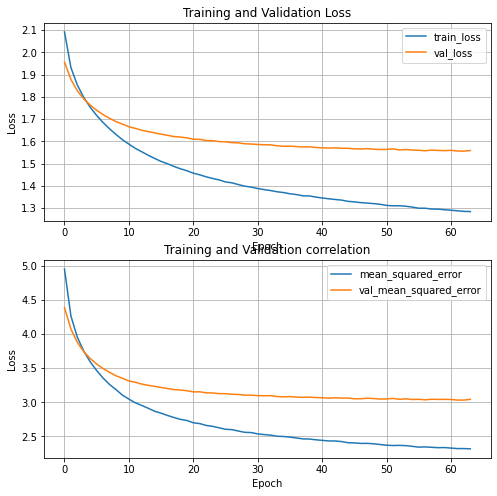

16/16 [==============================] - 0s 3ms/step
Correlación de Pearson: 0.31672707213798534


In [65]:
model = create_and_train_and_evaluate_model(mapped, mapped_val, embedding_size=100)

##### 2.2.Word2Vec + Mean ponderada (TF-IDF)

In [66]:
mapped = map_pairs(input_pairs, tf_idf_model=modelo_tfidf, dictionary=diccionario )
mapped_val = map_pairs(input_pairs_val, tf_idf_model=modelo_tfidf, dictionary=diccionario)

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_16 (Dense)               (None, 100)          10100       ['input_45[0][0]',               
                                                                  'input_46[0][0]']               
                                                                                                  
 tf.math.l2_normalize_44 (TFOpL  (None, 100)         0           ['dense_16[0][0]']        

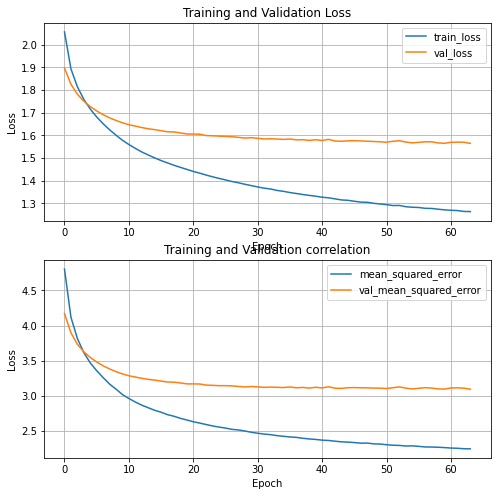

16/16 [==============================] - 0s 3ms/step
Correlación de Pearson: 0.30036529222154734


In [67]:
model = create_and_train_and_evaluate_model(mapped, mapped_val, embedding_size=100)

#### 3.Spacy

In [68]:
mapped = map_pairs(input_pairs, Spasii=True, dictionary=diccionario )
mapped_val = map_pairs(input_pairs_val, Spasii=True, dictionary=diccionario)

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_50 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 dense_18 (Dense)               (None, 300)          90300       ['input_49[0][0]',               
                                                                  'input_50[0][0]']               
                                                                                                  
 tf.math.l2_normalize_48 (TFOpL  (None, 300)         0           ['dense_18[0][0]']        

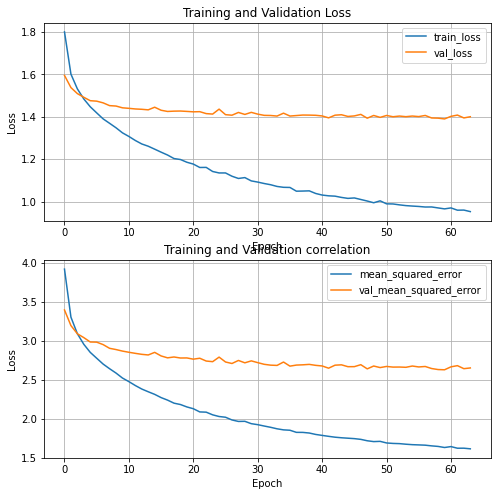

16/16 [==============================] - 0s 2ms/step
Correlación de Pearson: 0.27898310913701463


In [70]:
model = create_and_train_and_evaluate_model(mapped, mapped_val, embedding_size=300)

#### 4.RoBERTa

##### 4.1.CLS

In [75]:
mapped = map_pairs(input_pairs, RobertA=True, dictionary=diccionario )
mapped_val = map_pairs(input_pairs_val, RobertA=True, dictionary=diccionario)

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_55 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 input_56 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 dense_21 (Dense)               (None, 768)          590592      ['input_55[0][0]',               
                                                                  'input_56[0][0]']               
                                                                                                  
 tf.math.l2_normalize_54 (TFOpL  (None, 768)         0           ['dense_21[0][0]']        

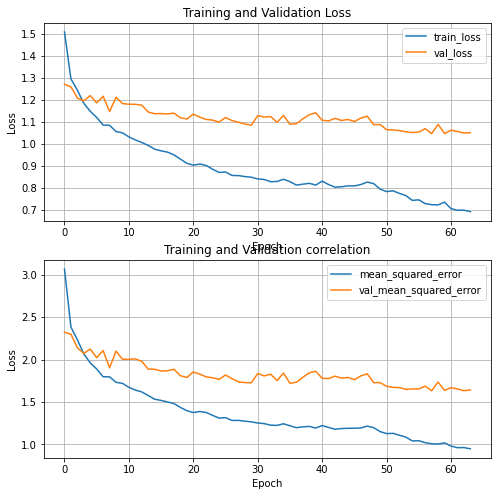

16/16 [==============================] - 0s 5ms/step
Correlación de Pearson: 0.21085842253443662


In [76]:
model = create_and_train_and_evaluate_model(mapped, mapped_val, embedding_size=768)

##### 4.2.MEAN

In [80]:
mapped = map_pairs(input_pairs, RobertA_Mean=True, dictionary=diccionario )
mapped_val = map_pairs(input_pairs_val, RobertA_Mean=True, dictionary=diccionario)

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_59 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 input_60 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 dense_23 (Dense)               (None, 768)          590592      ['input_59[0][0]',               
                                                                  'input_60[0][0]']               
                                                                                                  
 tf.math.l2_normalize_58 (TFOpL  (None, 768)         0           ['dense_23[0][0]']        

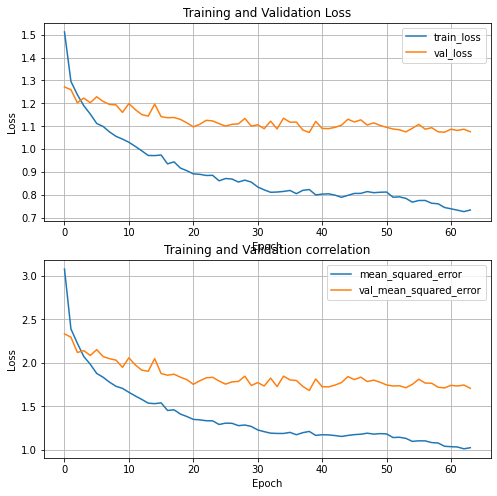

16/16 [==============================] - 0s 3ms/step
Correlación de Pearson: 0.2195821902305396


In [81]:
model = create_and_train_and_evaluate_model(mapped, mapped_val,embedding_size=768)

#### 5.RoBERTa FineTuned

Descarreguem el model i fem les prediccions amb la partició del val

In [5]:
model = 'projecte-aina/roberta-base-ca-v2-cased-sts'
tokenizer = AutoTokenizer.from_pretrained(model)
pipe = pipeline('text-classification', model=model, tokenizer=tokenizer)

def prepare(sentence_pairs):
    sentence_pairs_prep = []
    for s1, s2, _ in sentence_pairs:
        sentence_pairs_prep.append(f"{tokenizer.cls_token} {s1}{tokenizer.sep_token}{tokenizer.sep_token} {s2}{tokenizer.sep_token}")
    return sentence_pairs_prep


C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pelot\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [15]:
predictions = pipe(prepare(input_pairs_val), add_special_tokens=False)

# convert back to scores to the original 0 and 5 interval
valors_pred = []
valors_reals = []
for prediction, real in zip(predictions, input_pairs_val):
    valors_pred.append(logit(prediction['score']))
    valors_reals.append(real[2])

correlation, _ = pearsonr(valors_pred, valors_reals)
# Imprimir el coeficiente de correlación de Pearson
print(f"Correlación de Pearson: {correlation}")

Correlación de Pearson: 0.7522604358087148


### Analyze results
Taula de correlacions
|Nom del embedding|similaritat obtinguda en val|
|-|-|
|model_100mb|0.45|
|model_500mb|0.36|
|One-hot| 0.22|
|w2v_mean| 0.32|
|w2v_tfidf| 0.30|
|Spacy| 0.28|
|Roberta (CLS)| 0.21|
|Roberta_Mean| 0.22|
|Roberta Fine tuned| 0.75|

Respecte els model que hem creat nosaltres, el model que té l'embedding de 500 mb hauria de ser millor que el de 100 mb però en aquest cas no es cumpleix. Una possible causa es degut a que el vector és de 100 dimensions i per tant, es possible que la compressió de majors característiques en el model de 500 faci una mala jugada.

Cal destacar que la mida dels vectors de tots els models són de 100, excepte els de ROBERTA.

Per un costat, els embeddings que obtenen menys correlació en la seva predicció són ONE-HOT i els de ROBERTA (CLS i Mean). L'explicació de ONE-HOT és trivial, ja que no ofereix una bona representació de les paraules en forma de vector. A més a més, de que nomès agafem les 100 paraules més comuns i que, per tant, no hi és representat tot el vocabulari. Respecte els de ROBERTA, tot i que tenen unes dimensions superiors (de 768) no aconsegueixen un bon resultat, arribant a obtenir el mateix resultat que amb una codificació ONE-HOT.

Per altre costat, respecte els models w2v i de SPACY, observem com fent la mitjana del primer obtenim un millor resultat que en les altres opcions.

Finalment, cal destacar com el model de roberta fine tuned aconsegueix una de les millors correlacions en la seva predicció, això és degut a que aquest model transformer ha sigut expressament entrenat per aquesta tasca i per tant, el seu baseline és molt superior que si fessim la mlp a "mà".


## Train the same model with initiated trainable embeddings

In [36]:
# Preprocesamiento de las oraciones y creación del diccionario
sentences_1_preproc = [simple_preprocess(sentence_1) for sentence_1, _, _ in input_pairs]
sentences_2_preproc = [simple_preprocess(sentence_2) for _, sentence_2, _ in input_pairs]
sentence_pairs = list(zip(sentences_1_preproc, sentences_2_preproc))
# Versión aplanada para poder entrenar el modelo
sentences_pairs_flattened = sentences_1_preproc + sentences_2_preproc
diccionario = Dictionary(sentences_pairs_flattened)
REMAP_EMBEDDINGS = True
wv_model = None

def map_word_embeddings(
        sentence: str,
        sequence_len: int = 32,
        fixed_dictionary: Optional[Dictionary] = None
) -> np.ndarray:
    """
    Map to word-embedding indices
    :param sentence:
    :param sequence_len:
    :param fixed_dictionary:
    :return:
    """
    sentence_preproc = simple_preprocess(sentence)
    _vectors = np.zeros(sequence_len, dtype=np.int32)
    index = 0
    for word in sentence_preproc:
        if fixed_dictionary is not None:
            if word in fixed_dictionary.token2id:
                # Sumo 1 porque el valor 0 está reservado a padding
                _vectors[index] = fixed_dictionary.token2id[word] + 1
                index += 1
        else:
            if word in wv_model.key_to_index:
                _vectors[index] = wv_model.key_to_index[word] + 1
                index += 1
    return _vectors


def map_pairs_2(
        sentence_pairs: List[Tuple[str, str, float]],
        sequence_len: int = 32,
        fixed_dictionary: Optional[Dictionary] = None
) -> List[Tuple[Tuple[np.ndarray, np.ndarray], float]]:
    """
    Mapea los tripletes de oraciones a listas de (x, y), (pares de vectores, score)
    :param sentence_pairs:
    :param sequence_len:
    :param fixed_dictionary:
    :return:
    """
    # Mapeo de los pares de oraciones a pares de vectores
    pares_vectores = []
    for i, (sentence_1, sentence_2, similitud) in enumerate(sentence_pairs):
        vector1 = map_word_embeddings(sentence_1, sequence_len, fixed_dictionary)
        vector2 = map_word_embeddings(sentence_2, sequence_len, fixed_dictionary)
        # Añadir a la lista
        pares_vectores.append(((vector1, vector2), similitud))
    return pares_vectores

mapped = map_pairs_2(input_pairs, fixed_dictionary=diccionario if REMAP_EMBEDDINGS else None)
mapped_val = map_pairs_2(input_pairs_val, fixed_dictionary=diccionario if REMAP_EMBEDDINGS else None)



In [40]:
# Definir el Modelo
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
# Definir el Modelo
import tensorflow as tf
def build_and_compile_model(
        input_length: int = 32,
        dictionary_size: int = 1000,
        embedding_size: int = 16,
        learning_rate: float = 0.001,
        trainable: bool = False,
        pretrained_weights:bool = None
) -> tf.keras.Model:
    """
    Este es un modelo algo más avanzado. Calcula internamente una media ponderada de los word embeddings. Calcula también la proyección.
    :param input_length:
    :param hidden_size:
    :param dictionary_size:
    :param embedding_size:
    :param pretrained_weights:
    :param learning_rate:
    :param trainable:
    :return:
    """
    input_1, input_2 = tf.keras.Input((input_length, ), dtype=tf.int32, ), tf.keras.Input((input_length, ), dtype=tf.int32, )
    # Define Layers
    if pretrained_weights is None:
        embedding = tf.keras.layers.Embedding(
            dictionary_size, embedding_size, input_length=input_length, mask_zero=True, )
    else:
        dictionary_size = pretrained_weights.shape[0]
        embedding_size = pretrained_weights.shape[1]
        initializer = tf.keras.initializers.Constant(pretrained_weights)
        embedding = tf.keras.layers.Embedding(
            dictionary_size, embedding_size, input_length=input_length, mask_zero=True,
            embeddings_initializer=initializer, trainable=trainable, )
    # Pass through the layers
    _input_mask_1, _input_mask_2 = tf.not_equal(input_1, 0), tf.not_equal(input_2, 0)
    _embedded_1, _embedded_2 = embedding(input_1, ), embedding(input_2, )

    # Compute custom weights
    weights_computation = tf.keras.layers.Dense(1, name="weight_computation")
    dropout = tf.keras.layers.Dropout(0.2, name="dropout_in")
    _weights_1 = weights_computation(dropout(_embedded_1))
    weights_1 = tf.squeeze(_weights_1, axis=[-1])
    _weights_2 = weights_computation(dropout(_embedded_2))
    weights_2 = tf.squeeze(_weights_2, axis=[-1])
    # Define softmax
    softmax = tf.keras.layers.Softmax(name="weighted_sum_softmax")
    scores_1 = softmax(weights_1, mask=_input_mask_1)
    _pooled_1 = tf.math.reduce_sum(_embedded_1 * tf.expand_dims(scores_1, axis=-1), axis=1)
    scores_2 = softmax(weights_2, mask=_input_mask_2)
    _pooled_2 = tf.math.reduce_sum(_embedded_2 * tf.expand_dims(scores_2, axis=-1) , axis=1)
    # Compute the distance
    dense_output = tf.keras.layers.Dense(1)
    dropout_out = tf.keras.layers.Dropout(0.2, name="dropout_out")
    projected_1 = tf.linalg.l2_normalize(_pooled_1, axis=1, )
    projected_2 = tf.linalg.l2_normalize(_pooled_2, axis=1, )
    output = dense_output(dropout_out(projected_1 * projected_2), )

    # Define the model
    model = tf.keras.Model(inputs=(input_1, input_2, ), outputs=output,)
    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model

def create_and_train_and_evaluate_model(mapped, mapped_val,embedding_size:int=300, pretrained_weights = None):
    # Obtener las listas de train y test
    x_train, y_train = pair_list_to_x_y(mapped)
    x_val, y_val = pair_list_to_x_y(mapped_val)

    # Preparar los conjuntos de datos de entrenamiento y validación
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_dataset = val_dataset.batch(batch_size)

    # Construir y compilar el modelo
    model = build_and_compile_model(pretrained_weights=pretrained_weights, dictionary_size=len(diccionario.token2id)+1)
    # tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, )
    print(model.summary())
    # Entrenar el modelo
    history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

    

    y_pred: tf.RaggedTensor = model.predict(x_val)
    # Calcular la correlación de Pearson entre las predicciones y los datos de prueba
    correlation, _ = pearsonr(y_pred.flatten(), y_val.flatten())
    # Imprimir el coeficiente de correlación de Pearson
    print(f"Correlación de Pearson: {correlation}")

    return model

#### Random Embeddings (uniforme)

In [41]:
create_and_train_and_evaluate_model(mapped, mapped_val)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 32, 16)       162880      ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 dropout_in (Dropout)           (None, 32, 16)       0           ['embedding_4[0][0]',      

#### Word2Vec

Calculem els pesos pre-entrenats de embeddings

In [42]:
USE_PRETRAINED = True
wv_model = KeyedVectors.load_word2vec_format("data/model.bin", binary = True)


pretrained_weights: Optional[np.ndarray] = None
if USE_PRETRAINED:
    if REMAP_EMBEDDINGS:
        pretrained_weights = np.zeros(
            (len(diccionario.token2id) + 1, wv_model.vector_size),  dtype=np.float32)
        for token, _id in diccionario.token2id.items():
            if token in wv_model:
                pretrained_weights[_id + 1] = wv_model[token]
            else:
                # In W2V, OOV will not have a representation. We will use 0.
                pass
    else:
        # Not recommended (this will consume A LOT of RAM)
        pretrained_weights = np.zeros((wv_model.vectors.shape[0] + 1, wv_model.vector_size,),  dtype=np.float32)
        pretrained_weights[1:, :] = wv_model.vectors


In [43]:
create_and_train_and_evaluate_model(mapped, mapped_val, pretrained_weights = pretrained_weights)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 32, 100)      1018000     ['input_11[0][0]',               
                                                                  'input_12[0][0]']               
                                                                                                  
 dropout_in (Dropout)           (None, 32, 100)      0           ['embedding_5[0][0]',      

## Analyze results

Taula de correlacions
|Nom del embedding|similaritat obtinguda en val|
|----|----|
|Random embeddings|0.23|
|embeddings pre-entrenats|0.07|


Si ens fixem en la similaritat obtinguda en ambdós models, observem com els embeddings inicialitzats random, obtenen una millor mètrica que si li donem al model els embeddings pre-entrenats. 

Una possible causa d'aquest mal rendiment és degut a que els embeddings ja entrenats, com més o menys són una bona representació de les paraules, al ficar-los a la xarxa i, per tant, modificar-los a cada epoch, és possible que s'arribi a una pitjor representació que la inicial. En canvi, en la inicialització random la xarxa pot fer convergir aquests valors aleatoris cap a una representació millor a cada epoch, ja que inicialment no és una bona representació, a diferència dels embeddings pre-entrenats. 

## Opcional: Text classification

In [44]:
from datasets import load_dataset

dataset = load_dataset("projecte-aina/tecla")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset tecla downloaded and prepared to C:/Users/pelot/.cache/huggingface/datasets/projecte-aina___tecla/tecla/1.0.1/a0d9e053f5ad640d0203e50ca4cc4e254bdb7ff825b2ed4d4abc1ca640498ec6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Creem el diccionari i els input_pairs de trainning i de validació

In [46]:
## Introducir los datos de train y de validación
input_pairs = list(zip(dataset["train"]["text"], dataset["train"]["label1"], dataset["train"]["label2"]))
input_pairs_val = list(zip(dataset["validation"]["text"], dataset["validation"]["label1"], dataset["validation"]["label2"]))


# Preprocesamiento de las oraciones y creación del diccionario
sentences_1_preproc = [preprocess(sentence_1) for sentence_1, _, _ in input_pairs]
# Versión aplanada para poder entrenar el modelo
sentences_pairs_flattened = sentences_1_preproc

diccionario = Dictionary(sentences_pairs_flattened)

Modifiquem la funció de map_pairs per poder fer l'embedding d'aquest nou dataset

In [69]:
def creacio_one_hot(sentence, diccionario:Dictionary):
    diccionario.filter_extremes(no_below=5, no_above=0.5, keep_n=100)
    vector1 = np.zeros(len(diccionario.token2id), dtype=np.float)
    bow1 = diccionario.doc2bow(sentence)
    for index, count in bow1:
        vector1[index] = count

    return vector1

def map_tf_idf(sentence_preproc: List[str], dictionary: Dictionary, tf_idf_model: TfidfModel, wv_model) -> Tuple[List[np.ndarray], List[float]]:
    bow = dictionary.doc2bow(sentence_preproc)
    tf_idf = tf_idf_model[bow]
    vectors, weights = [], []
    for word_index, weight in tf_idf:
        word = dictionary.get(word_index)
        if word in wv_model:
            vectors.append(wv_model[word])
            weights.append(weight)
    return vectors, weights

def map_pairs(
        sentence_pairs: List[Tuple[str, str, float]],
        dictionary: Dictionary = None,
        tf_idf_model: TfidfModel = None,
        one_hot: bool = None,
        Spasii : bool = None,
        RobertA: bool = None,
        RobertA_Mean: bool = None,
        wv100: bool = None,
        wv500: bool = None,
        w2v_pre_mean: bool = None,
        RobertA_finetuned: bool = None
) -> List[Tuple[Tuple[np.ndarray, np.ndarray], float]]:
    """
    Mapea los tripletes de oraciones a listas de (x, y), (pares de vectores, score)
    :param sentence_pairs:
    :param dictionary:
    :param tf_idf_model:
    :return:
    """
    if one_hot:
        dictionary2 = Dictionary(sentences_pairs_flattened, prune_at=300)

    if Spasii:
        nlp = spacy.load("ca_core_news_md")
    if RobertA or RobertA_Mean:
        nlp = spacy.load("ca_core_news_trf")

    if wv100:
        wv_model = KeyedVectors.load_word2vec_format("data/word2vec100.bin", binary = True)

    if wv500:
        wv_model = KeyedVectors.load_word2vec_format("data/word2vec500.bin", binary = True)

    if w2v_pre_mean or tf_idf_model:
        wv_model = KeyedVectors.load_word2vec_format("data/model.bin", binary = True)


    # Mapeo de los pares de oraciones a pares de vectores
    pares_vectores = []
    for i, (sentence_1, label1, label2) in enumerate(sentence_pairs):
        sentence_1_preproc = preprocess(sentence_1)
        # Si usamos TF-IDF
        if tf_idf_model is not None:
            # Cálculo del promedio ponderado por TF-IDF de los word embeddings
            vectors1, weights1 = map_tf_idf(sentence_1_preproc, dictionary=dictionary, tf_idf_model=tf_idf_model, wv_model=wv_model )
            vector1 = np.average(vectors1, weights=weights1, axis=0, )

        elif wv100 is not None:
            vectors1 = [wv_model[word] for word in sentence_1_preproc if word in wv_model]
            vector1 = np.mean(vectors1, axis=0)

        elif wv500 is not None:
            vectors1 = [wv_model[word] for word in sentence_1_preproc if word in wv_model]
            vector1 = np.mean(vectors1, axis=0)

        elif one_hot is not None:
            vector1 = creacio_one_hot(sentence=sentence_1_preproc, diccionario=dictionary2)
            
        elif Spasii is not None:
            vector1 = nlp(" ".join(sentence_1_preproc)).vector

        elif RobertA is not None:
            vector1 = nlp(" ".join(sentence_1_preproc))._.trf_data.tensors[-1]
            vector1 = tf.squeeze(vector1)

        elif RobertA_Mean is not None:
            vectors1 = nlp(" ".join(sentence_1_preproc))._.trf_data.tensors[-1]
            vector1 = np.average(vectors1, axis=0)
            
        elif w2v_pre_mean is not None:
            # Cálculo del promedio de los word embeddings
            vectors1 = [wv_model[word] for word in sentence_1_preproc if word in wv_model]
            vector1 = np.mean(vectors1, axis=0)
        # Añadir a la lista
        pares_vectores.append((vector1, label1, label2))
    return pares_vectores

Fem mapping de les noves dades. Utilitzarem el model w2v de 100mb creat per nosaltres.

In [70]:
mapped = map_pairs(input_pairs, diccionario, wv100= True)
mapped_val = map_pairs(input_pairs_val, diccionario, wv100 = True)

Creem la funció de compilació i validació del model, on s'ha modificat el output de sortida amb una capa densa amb activació softmax. A més s'ha canviat la estructura de la xarxa per adequar la nova entrada.

In [121]:
def build_and_compile_model(hidden_size: int = 128, embedding_size: int = 300, learning_rate: float = 0.001, sortida:int = 53) -> tf.keras.Model:
    # Capa de entrada para los pares de vectores
    input_1 = tf.keras.Input(shape=(embedding_size,))

    # Capa oculta
    first_projection = tf.keras.layers.Dense(
        embedding_size,
        # activation='tanh',
        kernel_initializer=tf.keras.initializers.Identity(),
        bias_initializer=tf.keras.initializers.Zeros(),
    )
    projected_1 = first_projection(input_1)

    # Compute the cosine distance
    projected_1 = tf.linalg.l2_normalize(projected_1, axis=1, )
    output = tf.keras.layers.Dense(sortida, activation='softmax')
    output = output(projected_1)

    # Definir el modelo con las capas de entrada y salida
    model = tf.keras.Model(inputs=[input_1], outputs=output)


    # Compilar el modelo
    model.compile(loss="categorical_crossentropy", metrics="acc",
                  optimizer=tf.keras.optimizers.Adam(learning_rate))

    return model

def plot_training_curve(history):
    # Plot the training and validation loss and accuracy
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    ax[0].plot(history.history['loss'], label='train_loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training and Validation Loss')
    ax[0].grid(True)
    ax[0].legend()
    ax[1].plot(history.history['acc'], label='acc')
    ax[1].plot(history.history['val_acc'], label='val_acc')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Training and Validation correlation')
    ax[1].grid(True)
    ax[1].legend()
    plt.show()

# Definir constantes de entrenamiento
batch_size: int = 64
num_epochs: int = 32

def pair_list_to_x_y(pair_list: List[Tuple[Tuple[np.ndarray, np.ndarray], int]]) -> Tuple[Tuple[np.ndarray, np.ndarray], np.ndarray]:
    """
    Otiene las matrices X_1 (N x d) , X_2 (N x d), e Y (n) a partir de listas de parejas de vectores de oraciones - Listas de (d, d, 1)
    :param pair_list:
    :return:
    """
    _x, _y1, _y2 = zip(*pair_list)
    return (np.array(_x)), np.array(_y1, dtype=np.int, ) ,np.array(_y2, dtype=np.int, )


def create_and_train_and_evaluate_model(mapped, mapped_val,embedding_size:int=100):
    # Obtener las listas de train y test
    from keras.utils import to_categorical

    x_train, y_train1, y_train2 = pair_list_to_x_y(mapped)
    x_val, y_val1, y_val2 = pair_list_to_x_y(mapped_val)
    y_train1 = to_categorical(y_train1)
    y_train2 = to_categorical(y_train2)
    y_val1 = to_categorical(y_val1)
    y_val2 = to_categorical(y_val2)


    # Preparar los conjuntos de datos de entrenamiento y validación
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train1))
    train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

    train_dataset2 = tf.data.Dataset.from_tensor_slices((x_train, y_train2))
    train_dataset2 = train_dataset2.shuffle(buffer_size=len(x_train)).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val1))
    val_dataset = val_dataset.batch(batch_size)
    val_dataset2 = tf.data.Dataset.from_tensor_slices((x_val, y_val2))
    val_dataset2 = val_dataset2.batch(batch_size)

    # Construir y compilar el modelo
    model = build_and_compile_model(embedding_size=embedding_size, sortida = 4)
    # tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, )
    print(model.summary())
    # Entrenar el modelo
    history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

    plot_training_curve(history)

    y_pred = model.predict(x_val)
    y_pred = np.argmax(y_pred, axis=1)
    print("En la primera label")
    from keras.utils import to_categorical

    y_pred = to_categorical(y_pred)
    print(classification_report(y_val1, y_pred))

    model2 = build_and_compile_model(embedding_size=embedding_size, sortida= 53)

    history = model2.fit(train_dataset2, epochs=num_epochs, validation_data=val_dataset2)

    plot_training_curve(history)

    y_pred = model2.predict(x_val)
    y_pred = np.argmax(y_pred, axis=1)
    print("En la segona label")
    y_pred = to_categorical(y_pred)
    print(classification_report(y_val2, y_pred))

    return model

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_39 (Dense)            (None, 100)               10100     
                                                                 
 tf.math.l2_normalize_33 (TF  (None, 100)              0         
 OpLambda)                                                       
                                                                 
 dense_40 (Dense)            (None, 4)                 404       
                                                                 
Total params: 10,504
Trainable params: 10,504
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/32


C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:59: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1418/1418 [==============================] - 3s 2ms/step - loss: 0.3509 - acc: 0.8861 - val_loss: 0.2503 - val_acc: 0.9146
Epoch 2/32
1418/1418 [==============================] - 2s 1ms/step - loss: 0.2508 - acc: 0.9094 - val_loss: 0.2374 - val_acc: 0.9178
Epoch 3/32
1418/1418 [==============================] - 2s 1ms/step - loss: 0.2434 - acc: 0.9116 - val_loss: 0.2371 - val_acc: 0.9204
Epoch 4/32
1418/1418 [==============================] - 2s 1ms/step - loss: 0.2406 - acc: 0.9135 - val_loss: 0.2448 - val_acc: 0.9162
Epoch 5/32
1418/1418 [==============================] - 2s 1ms/step - loss: 0.2370 - acc: 0.9142 - val_loss: 0.2324 - val_acc: 0.9201
Epoch 6/32
1418/1418 [==============================] - 2s 1ms/step - loss: 0.2380 - acc: 0.9131 - val_loss: 0.2545 - val_acc: 0.9130
Epoch 7/32
1418/1418 [==============================] - 2s 1ms/step - loss: 0.2366 - acc: 0.9138 - val_loss: 0.2311 - val_acc: 0.9215
Epoch 8/32
1418/1418 [==============================] - 2s 1ms/step - los

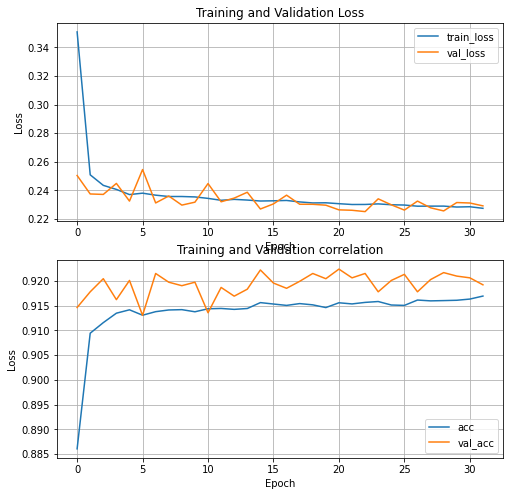

178/178 [==============================] - 0s 756us/step
En la primera label
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2306
           1       0.93      0.93      0.93      1599
           2       0.86      0.91      0.88      1018
           3       0.94      0.93      0.94       746

   micro avg       0.92      0.92      0.92      5669
   macro avg       0.92      0.92      0.92      5669
weighted avg       0.92      0.92      0.92      5669
 samples avg       0.92      0.92      0.92      5669

Epoch 1/32
1418/1418 [==============================] - 3s 1ms/step - loss: 2.0638 - acc: 0.4789 - val_loss: 1.4733 - val_acc: 0.6022
Epoch 2/32
1418/1418 [==============================] - 2s 1ms/step - loss: 1.3158 - acc: 0.6153 - val_loss: 1.2320 - val_acc: 0.6338
Epoch 3/32
1418/1418 [==============================] - 2s 1ms/step - loss: 1.1729 - acc: 0.6402 - val_loss: 1.1441 - val_acc: 0.6451
Epoch 4/32
1418/1418 [==========

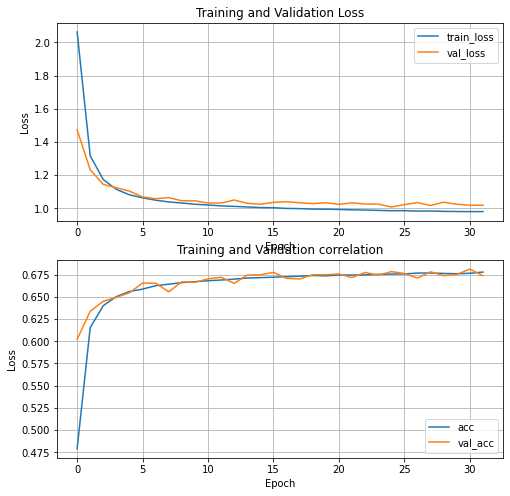

178/178 [==============================] - 0s 825us/step
En la segona label
              precision    recall  f1-score   support

           0       0.82      0.50      0.62        18
           1       0.66      0.59      0.62       109
           2       0.70      0.63      0.66       124
           3       0.69      0.57      0.62       261
           4       0.43      0.37      0.40        27
           5       0.70      0.93      0.80        15
           6       0.72      0.67      0.69       492
           7       0.57      0.62      0.59       169
           8       0.53      0.71      0.60       102
           9       0.69      0.73      0.71        93
          10       0.70      0.75      0.72       103
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         5
          13       0.60      0.62      0.61       407
          14       0.63      0.63      0.63        27
          15       0.69      0.56      0.62        48
     

C:\Users\pelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
create_and_train_and_evaluate_model(mapped, mapped_val,embedding_size=100)

Utilitzant 2 models de la xarxa, un per cada label, hem obtingut els següents resultats:
- label 1 => 92% d'accuracy
- label 2 => 53% d'accuracy